In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import itertools

In [3]:
inspire=pd.read_pickle('bigREFncgrams.pkl')
#np.array(pd.read_pickle('/Users/parisa/Documents/inspires_project/inspire/ReferenceReader/arxiv_labels.pkl'))
#f_refs=
#np.array(pd.read_pickle('/Users/parisa/Documents/inspires_project/inspire/ReferenceReader/arxiv_ref_fracs.pkl'))
#keywords=
#np.array(pd.read_pickle('/Users/parisa/Documents/inspires_project/inspire/ReferenceReader/arxiv_key_freq.pkl'))

In [4]:
#targets=np.reshape(labels,(len(labels),1))
#combi=np.concatenate((keywords,f_refs,targets),axis=1)
#headers=np.array(['Bigrams','Trigrams','Quadgrams','f_core','f_noncore','class'])
#inspire=pd.DataFrame(combi,columns=headers)

In [5]:
inspire=inspire.reindex(np.random.permutation(inspire.index))
inspire=inspire.reset_index(drop=True)
inspire.head()

,Text,NC score,core refs,non-core refs,Category,Result
0,Nucleation of symmetric domains in the coupled...,0,0.0,0.000,cond-mat.soft,0
1,Radial penetration of flux surface shaping in ...,0,0.0,0.000,physics.plasm-ph,0
2,From optimal transportation to optimal telepor...,0,0.0,0.000,math.PR,0
3,A multi-wavelength study of star formation act...,0,0.0,0.336,astro-ph.GA,0
4,Critical window for connectivity in the Config...,0,0.0,0.000,math.PR,0


In [6]:
training_samples = 3 * len(inspire) // 5
validation_samples = len(inspire) // 5

inspire_train = inspire[:training_samples]
inspire_val = inspire[training_samples:training_samples + validation_samples]
inspire_test = inspire[training_samples + validation_samples:]


In [7]:
#SVC classifier 
c_range=np.linspace(0.1,2,5)
parameters={'C':(c_range)
           #'decision_function_shape':('ovr','ovo'),
           }
SVC_clf = GridSearchCV(SVC(class_weight='balanced',probability=True),parameters,cv=3,scoring='accuracy',n_jobs=-1)
x_train = inspire_train[['core refs','non-core refs']]
y_train = inspire_train['Result']
SVC_clf.fit(x_train,y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([0.1  , 0.575, 1.05 , 1.525, 2.   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [8]:
print('Best score: %0.3f'% SVC_clf.best_score_)
print('Best parameters set:')
best_parameters = SVC_clf.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(param_name,best_parameters[param_name])

Best score: 0.887
Best parameters set:
C 0.1


In [9]:
#test classifier on validation data
x_val = inspire_val[['core refs','non-core refs']]
y_val = inspire_val['Result']
SVC_pred=SVC_clf.predict(x_val)

target_names=['CORE','NON-CORE', 'Rejected']
target_labels=[0,1,2]
report_SVC= classification_report(y_val,SVC_pred,labels=target_labels,target_names=target_names)
print (report_SVC)

             precision    recall  f1-score   support

       CORE       0.97      0.91      0.94      8131
   NON-CORE       0.40      0.70      0.51       815
   Rejected       0.92      0.85      0.88      1401

avg / total       0.92      0.88      0.90     10347



In [10]:
def plot_confusion_matrix(cm, classes,normalize=False,title='confusion matrix',cmap=plt.cm.Purples):
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print ("Normalised confusion matrix")
    else:
        print ("Confusion matrix")
    print (cm)
    
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    fmt='.2f' if normalize else 'd'
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),horizontalalignment='center',color='white' if cm[i,j]>thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

In [13]:
SVC_cm = confusion_matrix(y_val,SVC_pred.astype(np.int),labels=[2,1,0])

Normalised confusion matrix
[[0.84653819 0.09921485 0.05424697]
 [0.08834356 0.69693252 0.21472393]
 [0.00368958 0.08658222 0.9097282 ]]


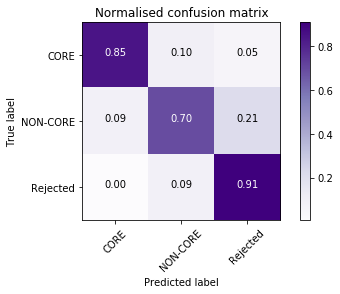

In [14]:
plt.figure()
plot_confusion_matrix(SVC_cm,classes=target_names,normalize=True,title='Normalised confusion matrix')
#plot_confusion_matrix(SVC_cm,classes=target_names,normalize=False,title='Normalised confusion matrix')
plt.show()